## cuGraph Notice 
The current version of cuGraph has some limitations:

* Vertex IDs need to be 32-bit integers.
* Vertex IDs are expected to be contiguous integers starting from 0.

cuGraph provides the renumber function to mitigate this problem. Input vertex IDs for the renumber function can be either 32-bit or 64-bit integers, can be non-contiguous, and can start from an arbitrary number. The renumber function maps the provided input vertex IDs to 32-bit contiguous integers starting from 0. cuGraph still requires the renumbered vertex IDs to be representable in 32-bit integers. These limitations are being addressed and will be fixed soon. 

### Test Data
We will be using the example graph provided:


![supply chain partitioning](../img/SC.png)


### Prep

In [1]:
# Import needed libraries
import cugraph
import cudf
import numpy as np

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

### Read data

In [3]:
# Test file    
datafile='../data/supplyChain-data.csv'

In [4]:
# read the data using cuDF
gdf = cudf.read_csv(datafile, delimiter=" ", names=['src', 'dst'], dtype=['int32', 'int32'] )

### Adjust the vertex ID

In [5]:
# Let's adjust all the vertex IDs to be zero based because of the cuGraph limitations
gdf["src"] = gdf["src"] - 1
gdf["dst"] = gdf["dst"] - 1

In [6]:
# We are going to try spectral clustering algorithm which requires that there are edge weights. 
# In this case all the weights are being set to 1
# gdf["data"] = cudf.Series(np.ones(len(gdf), dtype=np.float32))

In [7]:
# Look at the first few data records - the output should be two colums src and dst
gdf.head().to_pandas()

,src,dst
0,0,5
1,0,6
2,0,7
3,0,8
4,1,10


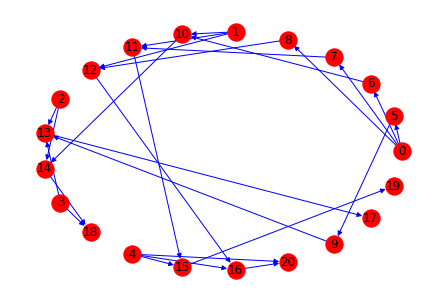

In [8]:
cpuG=nx.from_pandas_edgelist(gdf.to_pandas(), source='src', target='dst',create_using=nx.DiGraph)
nx.draw(cpuG, with_labels=True,node_color='r', edge_color='b', pos=nx.shell_layout(cpuG))
plt.show()

### Create the graph 

In [9]:
gpuG = cugraph.DiGraph()
gpuG.from_cudf_edgelist(gdf, source='src', target='dst')

In [10]:
print("Main Graph")
print("\tNumber of Vertices: " + str(gpuG.number_of_vertices()))
print("\tNumber of Edges:    " + str(gpuG.number_of_edges()))

Main Graph
	Number of Vertices: 21
	Number of Edges:    26


### Now compute the Core Number

Core Number computes the core number for every vertex of a graph G. A k-core of a graph is a maximal subgraph that contains nodes of degree k or more. A node has a core number of k if it belongs to a k-core but not to k+1-core. This call does not support a graph with self-loops and parallel edges.

In [11]:
core = cugraph.core_number(gpuG) 
#core

### Remove vertices with largest out degree

In [12]:
# a function to simply pulls out any edges that are incident on nodes that are contained in the remove-node list
def extract_subgraph_vertex(input_edges_df, remove_vertices_list):    
    output_edges_df = input_edges_df
    
    for i in range(len(remove_vertices_list)):
        remove_id = remove_vertices_list[i]
        output_edges_df = output_edges_df.query('src != @remove_id and dst != @remove_id')
  
    return output_edges_df

In [13]:
remove = core[ core['core_number'] == core['core_number'].max()]
subgraph1_gdf = extract_subgraph_vertex(gdf, remove['vertex'])
#subgraph1_gdf

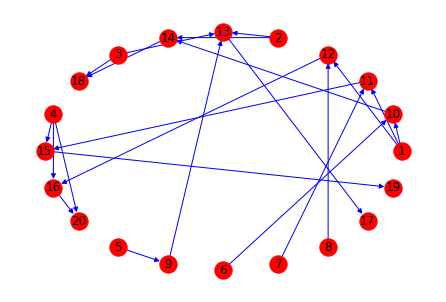

In [14]:
# draw the subgraph
cpuG=nx.from_pandas_edgelist(subgraph1_gdf.to_pandas(), source='src', target='dst',create_using=nx.DiGraph)
nx.draw(cpuG, with_labels=True,node_color='r', edge_color='b', pos=nx.shell_layout(cpuG))
plt.show()

### Check to see if the resulted subgraph is either strongly or weakly connected component

In [17]:
print('Is the subgraph strongly connected: ', nx.is_strongly_connected(cpuG))
print('Is the subgraph weakly connected: ', nx.is_weakly_connected(cpuG))

Is the subgraph strongly connected:  False
Is the subgraph weakly connected:  True


### Trial-and-error... cutting all the nodes with core number > 1

In [19]:
remove = core[ core['core_number'] > 1]
subgraph2_gdf = extract_subgraph_vertex(subgraph1_gdf, remove['vertex'])

### Weakly Connected Components

In [20]:
# first we have to renumber the sparse set of the src and dst vertex ides to a dense set of vertex ids using 
# all values contiguously starting from 0.
subgraph2_gdf['renumbered_src'], subgraph2_gdf['renumbered_dst'], mapping = cugraph.renumber(subgraph2_gdf['src'], subgraph2_gdf['dst'])
subgraph2_gdf

,src,dst,renumbered_src,renumbered_dst
14,5,9,0,4
15,6,10,1,5
16,7,11,2,6
17,8,12,3,7
18,9,13,4,8
19,10,14,5,9
20,11,15,6,10
21,12,16,7,11
22,13,17,8,12
23,14,18,9,13


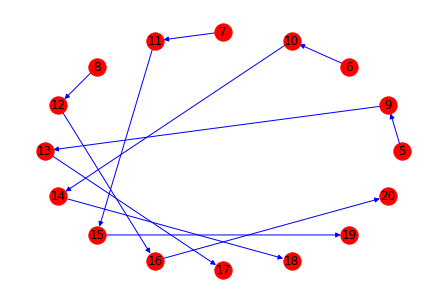

In [21]:
## draw the subgraph
cpuG=nx.from_pandas_edgelist(subgraph2_gdf.to_pandas(), source='src', target='dst',create_using=nx.DiGraph)
nx.draw(cpuG, with_labels=True,node_color='r', edge_color='b', pos=nx.shell_layout(cpuG))
plt.show()

In [22]:
print('Is the subgraph strongly connected: ', nx.is_strongly_connected(cpuG))
print('Is the subgraph weakly connected: ', nx.is_weakly_connected(cpuG))

Is the subgraph strongly connected:  False
Is the subgraph weakly connected:  False


In [24]:
# Currently cugraph WCC only supports undirected graph, so we have to use undirected Graph()

gpuG_undirected = cugraph.Graph()
gpuG_undirected.from_cudf_edgelist(subgraph2_gdf, source='renumbered_src', target='renumbered_dst')
wcc = cugraph.weakly_connected_components(gpuG_undirected)

In [28]:
label_gby = wcc.groupby('labels')
label_count = label_gby.count()
print("Total number of components found : ", len(label_count))

Total number of components found :  4


### Using the mapping to back out the original node indices

In [27]:
wcc['org_vertices'] = mapping[wcc['vertices']]
wcc

,labels,vertices,org_vertices
0,1,0,5
1,2,1,6
2,3,2,7
3,4,3,8
4,1,4,9
5,2,5,10
6,3,6,11
7,4,7,12
8,1,8,13
9,2,9,14


In [32]:
def print_components(_df, id):
    
    _f = _df.query('labels == @id')
  
    part = []
    for i in range(len(_f)):
        part.append(_f['org_vertices'][i] + 1)
    print(part)

In [34]:
for i in range(len(label_count)):
    print("Vertex Ids that belong to component label ", i+1, ": ")
    print_components(wcc, i+1)

Vertex Ids that belong to component label  1 : 
[6, 10, 14, 18]
Vertex Ids that belong to component label  2 : 
[7, 11, 15, 19]
Vertex Ids that belong to component label  3 : 
[8, 12, 16, 20]
Vertex Ids that belong to component label  4 : 
[9, 13, 17, 21]
